# Text Image deblurr using Deep Learning

In [61]:
# Check if GPU computation is possible
from tensorflow.config import list_physical_devices
print(list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Dataset creation

### Data analysis

In [2]:
import pandas as pd

splits = {'train': 'data/train/train_dataset.parquet', 'test': 'data/test/test_dataset.parquet'}
df = pd.read_parquet("hf://datasets/Zarakun/ukrainian_news/" + splits["train"])
df = df["text"]
df

/home/sense/miniconda3/envs/dnu-dl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0       Чверть українських учнів хотіли б виїхати за к...
1       На Рівненщині збільшився попит на купівлю неру...
2       2024 рік буде дорогим для водіїв у Німеччині, ...
3       Щодня від 50 000 до 85 000 осіб перетинають де...
4       Успіх та ефективність бізнесу напряму залежить...
                              ...                        
1722    Швейцарія розглядає можливість дозволити робот...
1723    Під час облаштування кухні дизайнери завжди ра...
1724    Виглядати стильно та модно зі застарілим вбран...
1725    Європейські країни є популярними напрямками дл...
1726    Діти дуже вибагливі у харчуванні. Причому част...
Name: text, Length: 1727, dtype: object

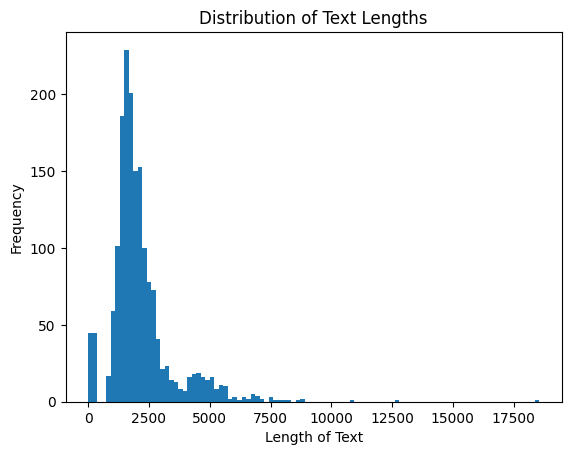

In [3]:
import matplotlib.pyplot as plt

text_lengths = df.str.len()
plt.hist(text_lengths, bins=100)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

### text2image converter with random parameters
returns two numpy arrays: first for the original and second with blur applied

In [3]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import textwrap
import os
import random
import numpy as np

IMAGE_WIDTH = 800
IMAGE_HEIGHT = 800

MIN_FONT_SIZE = 10
MAX_FONT_SIZE = 20

MIN_OFFSET_X = 0
MAX_OFFSET_X = 80
MIN_OFFSET_Y = 0
MAX_OFFSET_Y = 10

def gen_image(text, output_path="", fonts_path = "./fonts/", image_size=(IMAGE_WIDTH,IMAGE_HEIGHT)):
    # list all font files in the fonts_path directory
    font_paths = [os.path.join(fonts_path, file) for file in os.listdir(fonts_path) if file.endswith('.ttf') or file.endswith(".TTF")]

    # create blank image
    img = Image.new('L', image_size, color=255)
    draw = ImageDraw.Draw(img)

    # random font size and path
    font_size = random.randint(MIN_FONT_SIZE, MAX_FONT_SIZE)
    font_path = random.choice(font_paths)
    font = ImageFont.truetype(font_path, font_size)

    # random alignment
    alignment = random.choice(['left', 'center', 'right'])

    # wrap the text
    offset_x = random.randint(MIN_OFFSET_X,MAX_OFFSET_X)
    offset_y = random.randint(MIN_OFFSET_Y,MAX_OFFSET_Y)
    wrapped_text = textwrap.fill(text, width=70)

    # draw text
    draw.multiline_text((offset_x, offset_y), wrapped_text, font=font, fill=0, align=alignment)

    # apply Gaussian blur [1-2] based on the font size (smaller font -> less blurr)
    blur_radius = (font_size - MIN_FONT_SIZE) / (MAX_FONT_SIZE - MIN_FONT_SIZE) + 1
    blurred_img = img.filter(ImageFilter.GaussianBlur(blur_radius))

    # save image
    if output_path != "":
        # create output dirs if don't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        img.save(output_path)
    
    return [np.array(img), np.array(blurred_img)]

### Check one generated image (optional) 

In [31]:
'''
test image generation of text with length that represents 75% of texts lengths
'''

# get text with length of third quartile of lengths distribution
text_lengths = df.str.len()
Q3 = text_lengths.quantile(0.75)
q3_text = df[text_lengths[text_lengths == Q3].index[0]]

# generate same text multiple times to check random parameters
for i in range(0,10):
    gen_image(q3_text, f"./input/generated/test_{i}.png")

In [8]:
'''
delete generated image
'''
import os

# Delete the /input folder
if os.path.exists('./input/generated'):
    os.system('rm -rf ./input')

### translate texts to np.array images

In [9]:
import numpy as np

images = []
blurred_images = []

for text in df:
    img, blurred_img = gen_image(text)
    images.append(img)
    blurred_images.append(blurred_img)

images = np.array(images)
blurred_images = np.array(blurred_images)

print(f"images shape: {images.shape}")
print(f"blurred_images shape: {blurred_images.shape}")

images shape: (1727, 800, 800)
blurred_images shape: (1727, 800, 800)


### split into train/test and save

In [10]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

os.makedirs('./input/ds', exist_ok=True)

X_train, X_test = train_test_split(blurred_images, test_size=0.1, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
np.save('./input/ds/X_train.npy', X_train)
np.save('./input/ds/X_test.npy', X_test)

y_train, y_test = train_test_split(images, test_size=0.1, random_state=42)
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
np.save('./input/ds/y_train.npy', y_train)
np.save('./input/ds/y_test.npy', y_test)

X_train shape: (1554, 800, 800)
X_test shape: (173, 800, 800)
y_train shape: (1554, 800, 800)
y_test shape: (173, 800, 800)


# Model

In [4]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_deblurring_model(input_shape):
    input_img = Input(shape=(input_shape[0], input_shape[1], 1))

    x = Conv2D(256, (5, 5), padding='same', activation='relu')(input_img)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(1, (1, 1), padding='same', activation='relu')(x)

    model = Model(input_img, x)
    model.compile(
        optimizer=Adam(), 
        loss='mean_squared_error', 
        metrics=['mae']
    )
    return model

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT)
deblurring_model = build_deblurring_model(input_shape)
deblurring_model.summary()

I0000 00:00:1735022934.242219    7948 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 800, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 800, 800, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 800, 800, 256)  │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 800, 800, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 800, 800, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 800, 800, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 800, 800, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 800, 800, 1)    │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 398,593 (1.52 MB)

 Trainable params: 398,593 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
import tensorflow as tf

def normalize_data(x):
    return x / 255.0

def split_indices(num_samples, validation_split=0.2):
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    split_idx = int(num_samples * (1 - validation_split))
    return indices[:split_idx], indices[split_idx:]

def tf_data_generator(x_file, y_file, indices, batch_size=32):
    x_data = np.load(x_file, mmap_mode='r')
    y_data = np.load(y_file, mmap_mode='r')

    def gen():
        for idx in indices:
            yield x_data[idx], y_data[idx]

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=x_data.shape[1:], dtype=tf.float32),
            tf.TensorSpec(shape=y_data.shape[1:], dtype=tf.float32),
        )
    )

    dataset = dataset.map(lambda x, y: (normalize_data(x), normalize_data(y)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

callbacks = [early_stopping, reduce_lr]

In [1]:
from tensorflow.config.experimental import list_physical_devices, set_memory_growth

gpus = list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

from tensorflow.keras import backend
from tensorflow.keras import mixed_precision
backend.clear_session()

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

2024-12-24 07:48:40.393401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735022920.404239    7948 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735022920.407422    7948 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 07:48:40.418794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import numpy as np

x_file = './input/ds/X_train.npy'
y_file = './input/ds/y_train.npy'

# Load data shape
num_samples = np.load(x_file, mmap_mode='r').shape[0]

# Split indices for training and validation
train_indices, val_indices = split_indices(num_samples, validation_split=0.2)

# Create datasets
batch_size = 2
train_dataset = tf_data_generator(x_file, y_file, train_indices, batch_size).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = tf_data_generator(x_file, y_file, val_indices, batch_size).repeat().prefetch(tf.data.AUTOTUNE)

# Calculate steps
train_steps_per_epoch = len(train_indices) // batch_size
val_steps_per_epoch = len(val_indices) // batch_size

# Model compilation
deblurring_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

# Model training with validation
history = deblurring_model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1735023062.016715    8064 service.cc:148] XLA service 0x562a7fb866f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735023062.016749    8064 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-12-24 07:51:02.035992: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735023062.199862    8064 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1735023063.059411    8064 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735023063.201593    8064 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-12-24 07:51:16.330596: E externa

621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0858 - mae: 0.1458

E0000 00:00:1735023341.352922    8062 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735023341.501024    8062 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


621/621 ━━━━━━━━━━━━━━━━━━━━ 290s 133ms/step - loss: 0.0857 - mae: 0.1457 - val_loss: 0.0103 - val_mae: 0.0509 - learning_rate: 0.0010
Epoch 2/30


E0000 00:00:1735023351.799738    8062 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735023351.933208    8062 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-12-24 07:56:03.558114: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=3} for conv (f16[128,3,3,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[1,800,800,256]{3,2,1,0}, f16[1,800,800,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-24 07:56

620/621 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0095 - mae: 0.0438

E0000 00:00:1735023528.439544    8064 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735023528.578137    8064 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


621/621 ━━━━━━━━━━━━━━━━━━━━ 184s 126ms/step - loss: 0.0095 - mae: 0.0437 - val_loss: 0.0080 - val_mae: 0.0475 - learning_rate: 0.0010
Epoch 3/30
621/621 ━━━━━━━━━━━━━━━━━━━━ 75s 121ms/step - loss: 0.0079 - mae: 0.0411 - val_loss: 0.0209 - val_mae: 0.0786 - learning_rate: 0.0010
Epoch 4/30
621/621 ━━━━━━━━━━━━━━━━━━━━ 75s 121ms/step - loss: 0.0114 - mae: 0.0460 - val_loss: 0.0069 - val_mae: 0.0293 - learning_rate: 0.0010
Epoch 5/30
621/621 ━━━━━━━━━━━━━━━━━━━━ 77s 124ms/step - loss: 0.0069 - mae: 0.0324 - val_loss: 0.0059 - val_mae: 0.0296 - learning_rate: 0.0010
Epoch 6/30
621/621 ━━━━━━━━━━━━━━━━━━━━ 75s 121ms/step - loss: 0.0059 - mae: 0.0298 - val_loss: 0.0052 - val_mae: 0.0236 - learning_rate: 0.0010
Epoch 7/30
621/621 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - loss: 0.0053 - mae: 0.0278 - val_loss: 0.0050 - val_mae: 0.0287 - learning_rate: 0.0010
Epoch 8/30
621/621 ━━━━━━━━━━━━━━━━━━━━ 70s 113ms/step - loss: 0.0051 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0253 - learning_rate: 0.

In [9]:
import matplotlib.pyplot as plt

def acc_loss_plot(history, name="", metric="accuracy"):

    met = history.history[metric]
    val_met = history.history["val_"+metric]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))

    _, axarr = plt.subplots(1, 2, figsize=(12, 4))
    axarr[0].set_title(f"{metric} {name}")
    axarr[0].plot(epochs, met, label="train")
    axarr[0].plot(epochs, val_met, label="val")
    axarr[0].set_xlabel("Epochs")
    axarr[0].legend()
    
    axarr[1].set_title("Loss " + name)
    axarr[1].plot(epochs, loss, label="train")
    axarr[1].plot(epochs, val_loss, label="val")
    axarr[1].set_xlabel("Epochs")
    axarr[1].legend()

    plt.show()

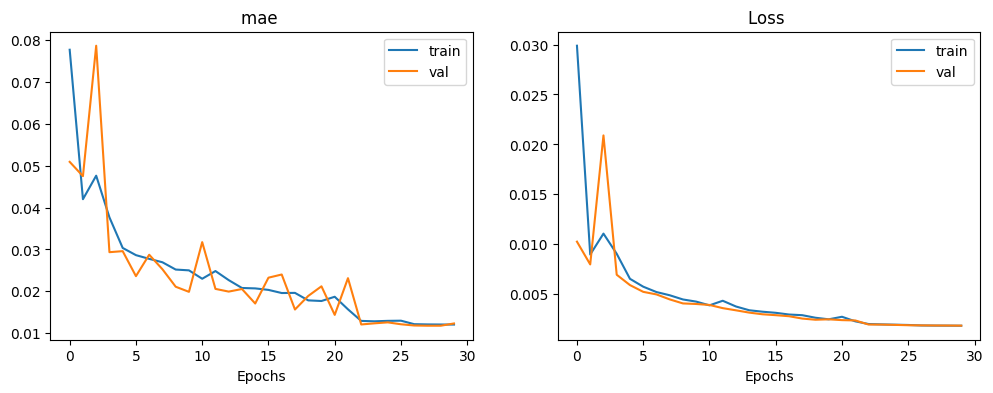

In [10]:
acc_loss_plot(history, metric="mae")

In [11]:
deblurring_model.save("./deblurring_model.keras")

# Evaluation

In [62]:
from tensorflow.keras.models import load_model

IMAGE_WIDTH = 800
IMAGE_HEIGHT = 800

deblurring_model = load_model("./deblurring_model.keras")

In [63]:
import tensorflow as tf
import numpy as np

def normalize_data(x):
    return x / 255.0

def test_data_generator(x_file, y_file, batch_size=32):
    def gen():
        x_data = np.load(x_file, mmap_mode='r')
        y_data = np.load(y_file, mmap_mode='r')
        num_samples = x_data.shape[0]
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_batch = x_data[start_idx:end_idx]
            y_batch = y_data[start_idx:end_idx]
            yield normalize_data(X_batch), normalize_data(y_batch)

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, *np.load(x_file, mmap_mode='r').shape[1:]), dtype=tf.float32),
            tf.TensorSpec(shape=(None, *np.load(y_file, mmap_mode='r').shape[1:]), dtype=tf.float32),
        )
    )

# Load test dataset
test_file_x = './input/ds/X_test.npy'
test_file_y = './input/ds/y_test.npy'

# Create test dataset
test_dataset = test_data_generator(test_file_x, test_file_y, batch_size=2)

# Calculate the number of steps for evaluation
num_test_samples = np.load(test_file_x, mmap_mode='r').shape[0]
test_steps = num_test_samples // 2  # Adjust batch size if necessary

# Evaluate the model
test_loss, test_mae = deblurring_model.evaluate(test_dataset, steps=test_steps)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0020 - mae: 0.0135
Test Loss: 0.0018520039739087224
Test MAE: 0.012528655119240284


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


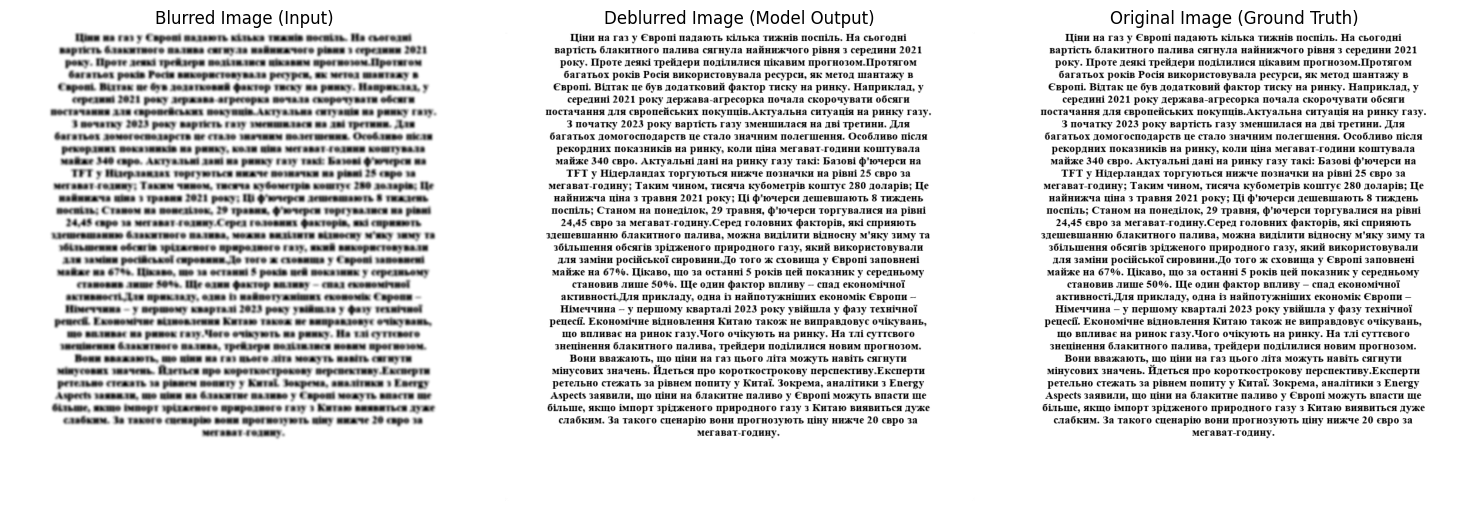

True

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Function to display images
def display_images(input_image, predicted_image, ground_truth):
    plt.figure(figsize=(15, 5))

    # Input image
    plt.subplot(1, 3, 1)
    plt.title("Blurred Image (Input)")
    plt.imshow(input_image, cmap='gray')
    plt.axis('off')

    # Predicted image
    plt.subplot(1, 3, 2)
    plt.title("Deblurred Image (Model Output)")
    plt.imshow(predicted_image, cmap='gray')
    plt.axis('off')

    # Ground truth
    plt.subplot(1, 3, 3)
    plt.title("Original Image (Ground Truth)")
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load one sample from the test set
x_test_data = np.load('./input/ds/X_test.npy', mmap_mode='r')
y_test_data = np.load('./input/ds/y_test.npy', mmap_mode='r')

# Normalize one sample
index = 5
input_image = normalize_data(x_test_data[index])
ground_truth = normalize_data(y_test_data[index])

# Predict using the model
predicted_image = deblurring_model.predict(input_image[np.newaxis, ...])[0]
predicted_image = np.clip(predicted_image, 0, 1)
predicted_image = (predicted_image * 255).astype(np.uint8)

# Display the images
display_images(input_image, predicted_image, ground_truth)

# Save the images
os.makedirs(os.path.dirname("./output/"), exist_ok=True)
input_image_uint8 = np.clip(input_image * 255, 0, 255).astype(np.uint8)
ground_truth_uint8 = np.clip(ground_truth * 255, 0, 255).astype(np.uint8)

cv2.imwrite('./output/img_input.png', input_image_uint8)
cv2.imwrite('./output/img_predicted.png', predicted_image)
cv2.imwrite('./output/img_ground_truth.png', ground_truth_uint8)


# Test with custom image

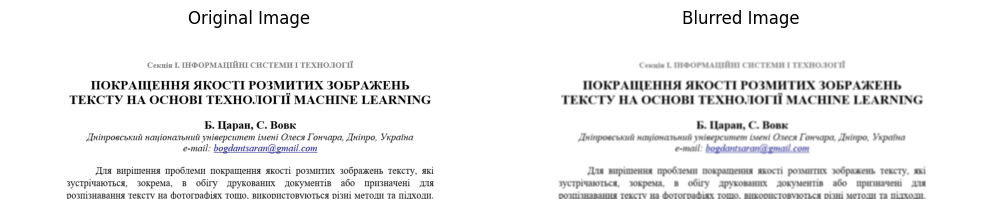

True

In [65]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

# Load the original image
original_image_path = './test/test_img.png'
original_image = cv2.imread(original_image_path)

if original_image is None:
    raise FileNotFoundError("The image path is invalid or the image doesn't exist.")

# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(original_image, (5, 5), sigmaX=2)

# Display the original and blurred images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Blurred Image")
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

cv2.imwrite('./test/test_img_blurred.png', blurred_image)

Original Width: 1082, Original Height: 378
Target Width: 800, Target Height: 800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


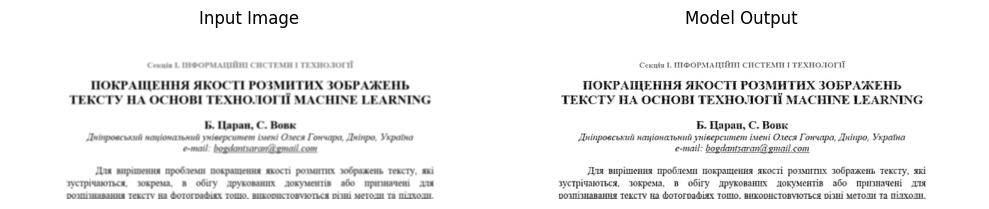

True

In [66]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def normalize_image(img):
    return img / 255.0

def display_image(input_image, predicted_image):
    plt.figure(figsize=(10, 5))

    # Input image
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(input_image, cmap='gray')
    plt.axis('off')

    # Predicted image
    plt.subplot(1, 2, 2)
    plt.title("Model Output")
    plt.imshow(predicted_image, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def resize_with_aspect_ratio(img, target_width, target_height):
    """
    Resize the image while preserving its aspect ratio to fit within the target dimensions.
    """
    original_height, original_width = img.shape
    print(f"Original Width: {original_width}, Original Height: {original_height}")
    print(f"Target Width: {target_width}, Target Height: {target_height}")
    
    # Calculate scale factors for width and height
    scale_width = target_width / original_width
    scale_height = target_height / original_height
    scale = min(scale_width, scale_height)

    # New dimensions
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # Resize image
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Calculate padding
    top_padding = (target_height - new_height) // 2
    bottom_padding = target_height - new_height - top_padding
    left_padding = (target_width - new_width) // 2
    right_padding = target_width - new_width - left_padding

    # Pad with ones (white) to match the target dimensions
    padded_img = cv2.copyMakeBorder(
        resized_img,
        top_padding,
        bottom_padding,
        left_padding,
        right_padding,
        borderType=cv2.BORDER_CONSTANT,
        value=(255, 255, 255),
    )

    # Return padded image and padding information
    return padded_img, (top_padding, bottom_padding, left_padding, right_padding)

def resize_back_to_original(predicted_img, padding, original_shape):
    """
    Crop the model's output and resize it to the original dimensions.
    """
    top_padding, bottom_padding, left_padding, right_padding = padding

    # Crop the image to remove padding
    cropped_img = predicted_img[
        top_padding: -bottom_padding if bottom_padding > 0 else None,
        left_padding: -right_padding if right_padding > 0 else None
    ]

    # Ensure cropping resulted in a non-empty image
    if cropped_img.size == 0:
        raise ValueError("Cropping resulted in an empty image. Check padding values.")

    # Resize to match original dimensions
    expected_height, expected_width = original_shape
    resized_img = cv2.resize(cropped_img, (expected_width, expected_height), interpolation=cv2.INTER_AREA)

    return resized_img

# Load your custom image
custom_image_path = './test/test_img_blurred.png'
custom_image = cv2.imread(custom_image_path, cv2.IMREAD_GRAYSCALE)
if custom_image is None:
    raise FileNotFoundError("The image path is invalid or the image doesn't exist.")
original_height, original_width = custom_image.shape
original_shape = (original_height, original_width)

# Resize to match model input and store padding
resized_image, padding = resize_with_aspect_ratio(custom_image, IMAGE_WIDTH, IMAGE_HEIGHT)

# Normalize the resized image
normalized_image = normalize_image(resized_image)

# Predict with model
predicted_image = deblurring_model.predict(normalized_image[np.newaxis, ...])[0]
predicted_image = np.clip(predicted_image, 0, 1)
predicted_image = (predicted_image * 255).astype(np.uint8)

# Resize prediction back to original dimensions
predicted_image_resized_back = resize_back_to_original(predicted_image, padding, original_shape)

# Display the images
display_image(custom_image, predicted_image_resized_back)

# Save the images
cv2.imwrite('./test/test_img_predicted.png', predicted_image)
cv2.imwrite('./test/test_img_predicted_resized.png', predicted_image_resized_back)
